In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/VO_TARVERDIAN')

In [13]:
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
import librosa.display
import os
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.stats import kurtosis, skew
import librosa.feature
from scipy import signal
from utils.audio_features import AudioFeatureExtractor
import glob

In [4]:
zip_path = '/content/drive/MyDrive/VO_TARVERDIAN/data.zip'
extract_folder = '/content/data'
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)


In [5]:
#CONSTANT
TRAIN_PATH = "/content/data/data/train.csv"
Y_TRAIN_PATH = "/content/data/data/Y_train_ofTdMHi.csv"
X_SUBMIT_PATH = "/content/data/data/X_soumettre.csv"

X_TRAIN_DOSSIER_PATH = "/content/data/data/X_train"
X_SUBMIT_DOSSIER_PATH = "/content/data/data/X_test"
Y_SUBMIT_PATH = "/content/data/data/submission.csv"


# Analyze the target variable

In [6]:
y_train = pd.read_csv(Y_TRAIN_PATH)

In [7]:
y_train.head()

,id,pos_label
0,00000-JAM.wav,0.0
1,00001-JAM.wav,1.0
2,00002-JAM.wav,1.0
3,00003-JAM.wav,1.0
4,00004-JAM.wav,1.0


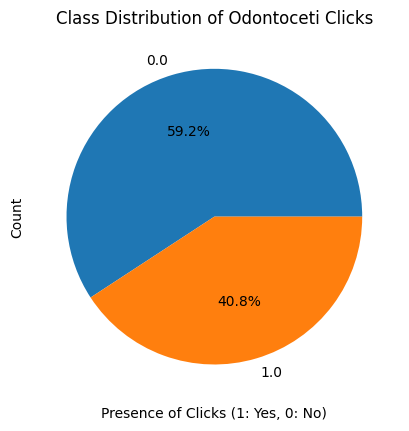

In [8]:
#Visualize the repartition of the target variable
y_train['pos_label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title("Class Distribution of Odontoceti Clicks")
plt.xlabel("Presence of Clicks (1: Yes, 0: No)")
plt.ylabel("Count")
plt.show()


In [9]:
# Extract location information from file names
y_train["location"] = y_train["id"].apply(lambda x: x.split("-")[-1].split(".")[0])

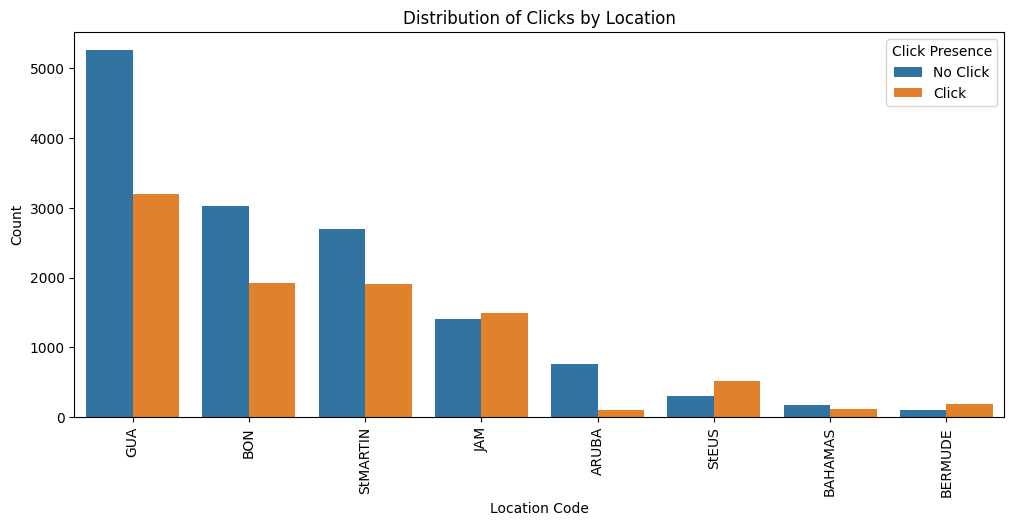

In [10]:
# Location-based distribution plot
plt.figure(figsize=(12, 5))
sns.countplot(x=y_train["location"], hue=y_train["pos_label"], order=y_train["location"].value_counts().index)
plt.xticks(rotation=90)
plt.title("Distribution of Clicks by Location")
plt.xlabel("Location Code")
plt.ylabel("Count")
plt.legend(title="Click Presence", labels=["No Click", "Click"])
plt.show()

Certain locations may have more odontoceti clicks, indicating regional differences in marine life activity.

# Audio Data Exploration


--- File 1/5: 04207-GUA.wav ---


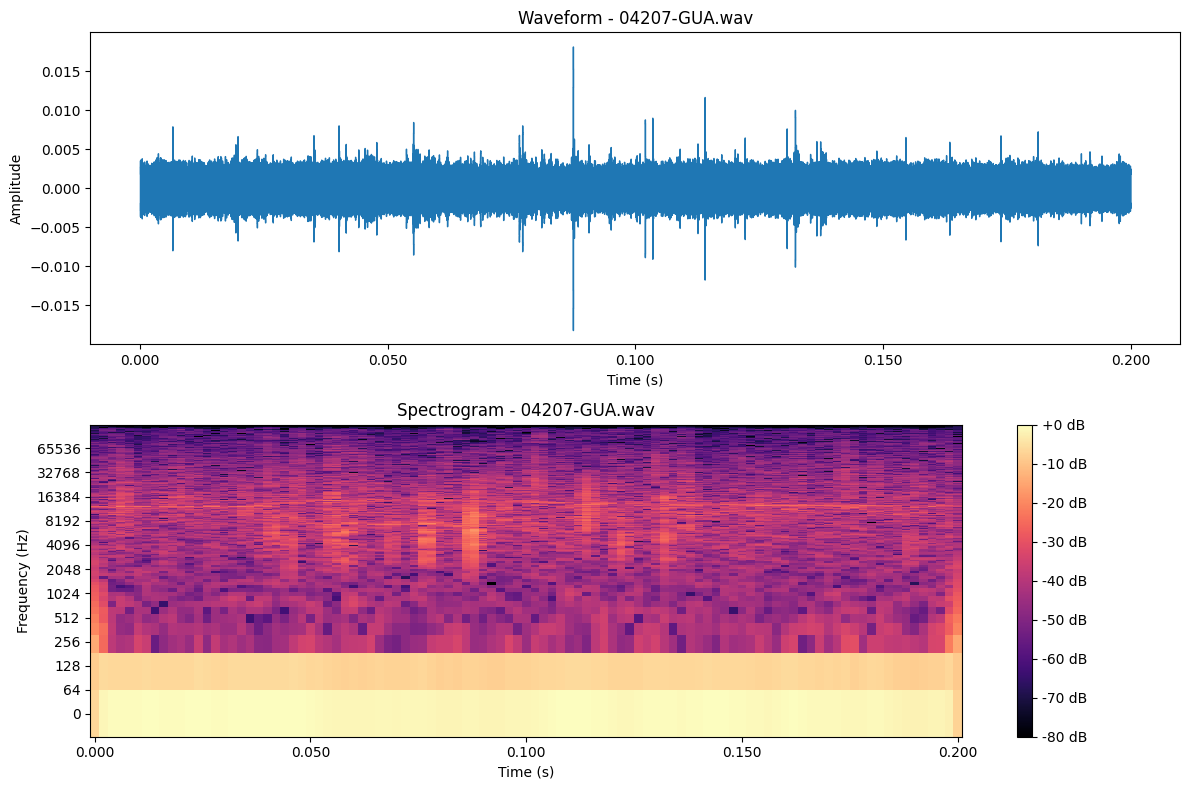

/usr/local/lib/python3.11/dist-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


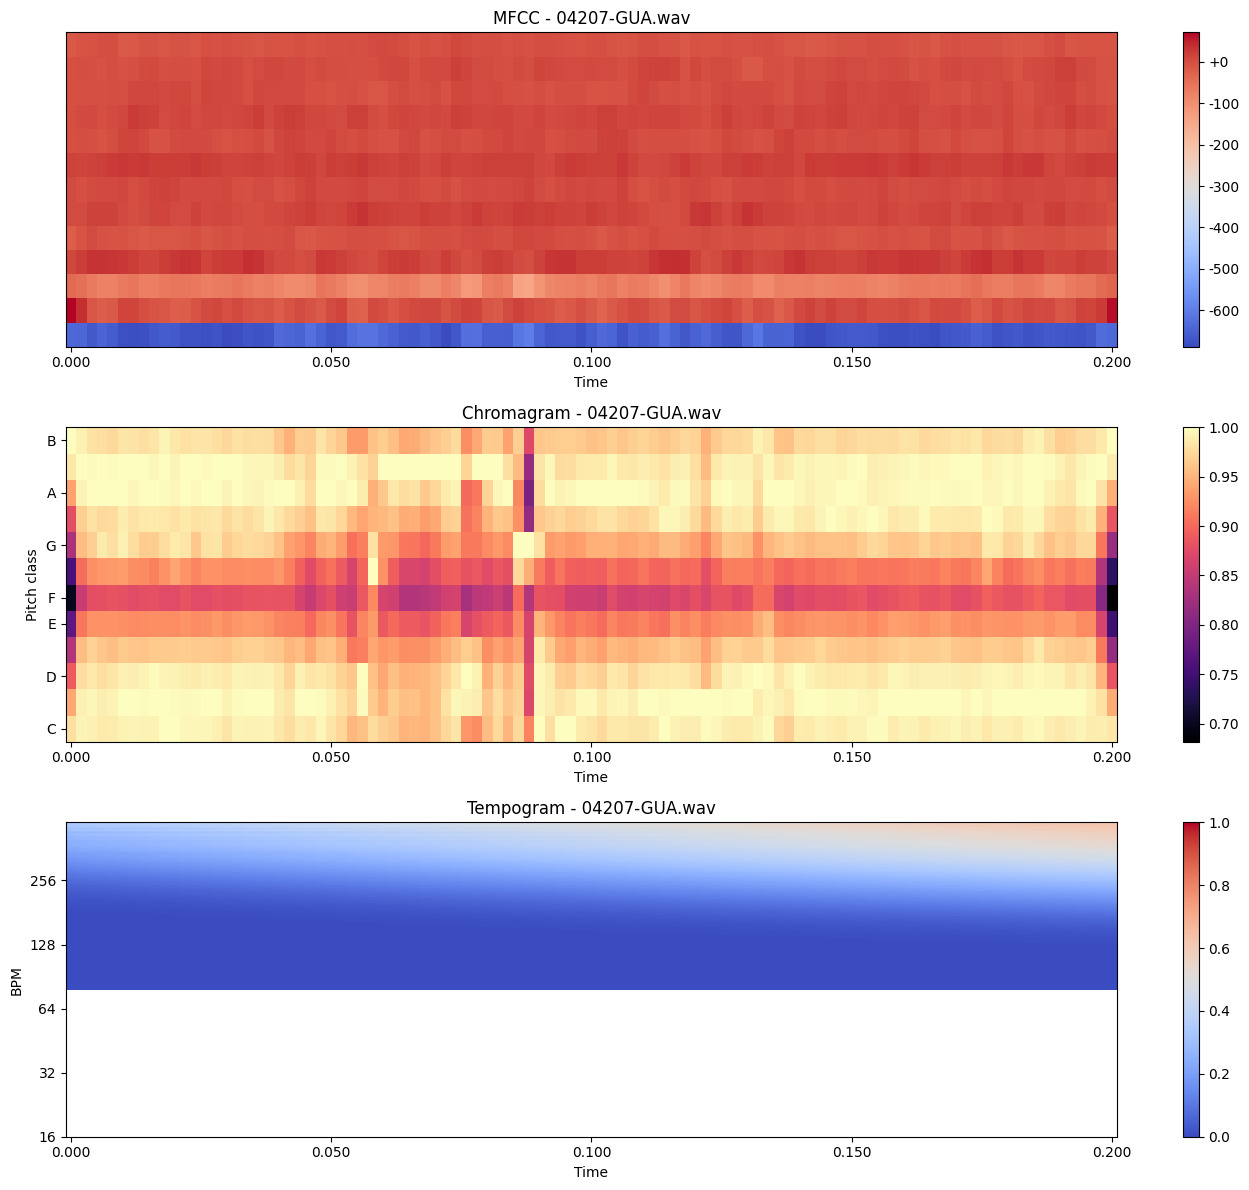


Information for 04207-GUA.wav:
Sample rate: 256000 Hz
Duration: 0.20 seconds
Number of samples: 51200
Estimated tempo: 138.25 BPM

--- File 2/5: 12817-JAM.wav ---


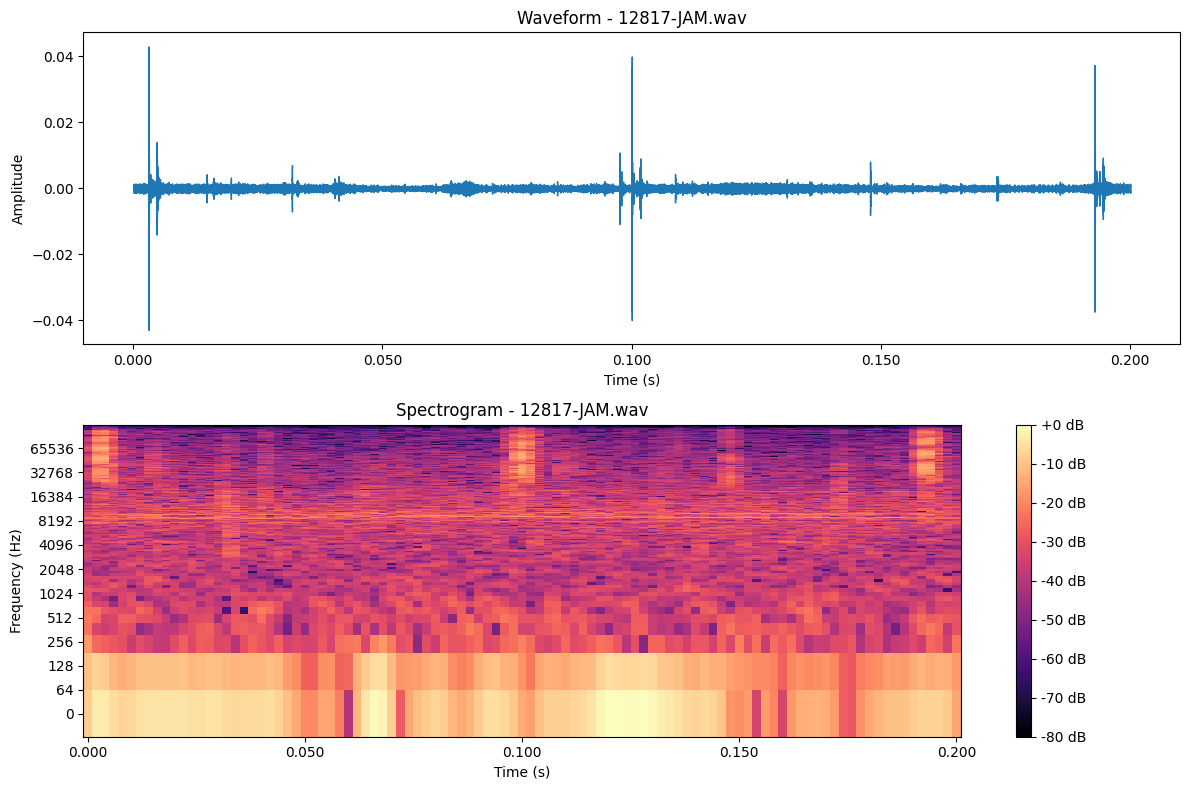

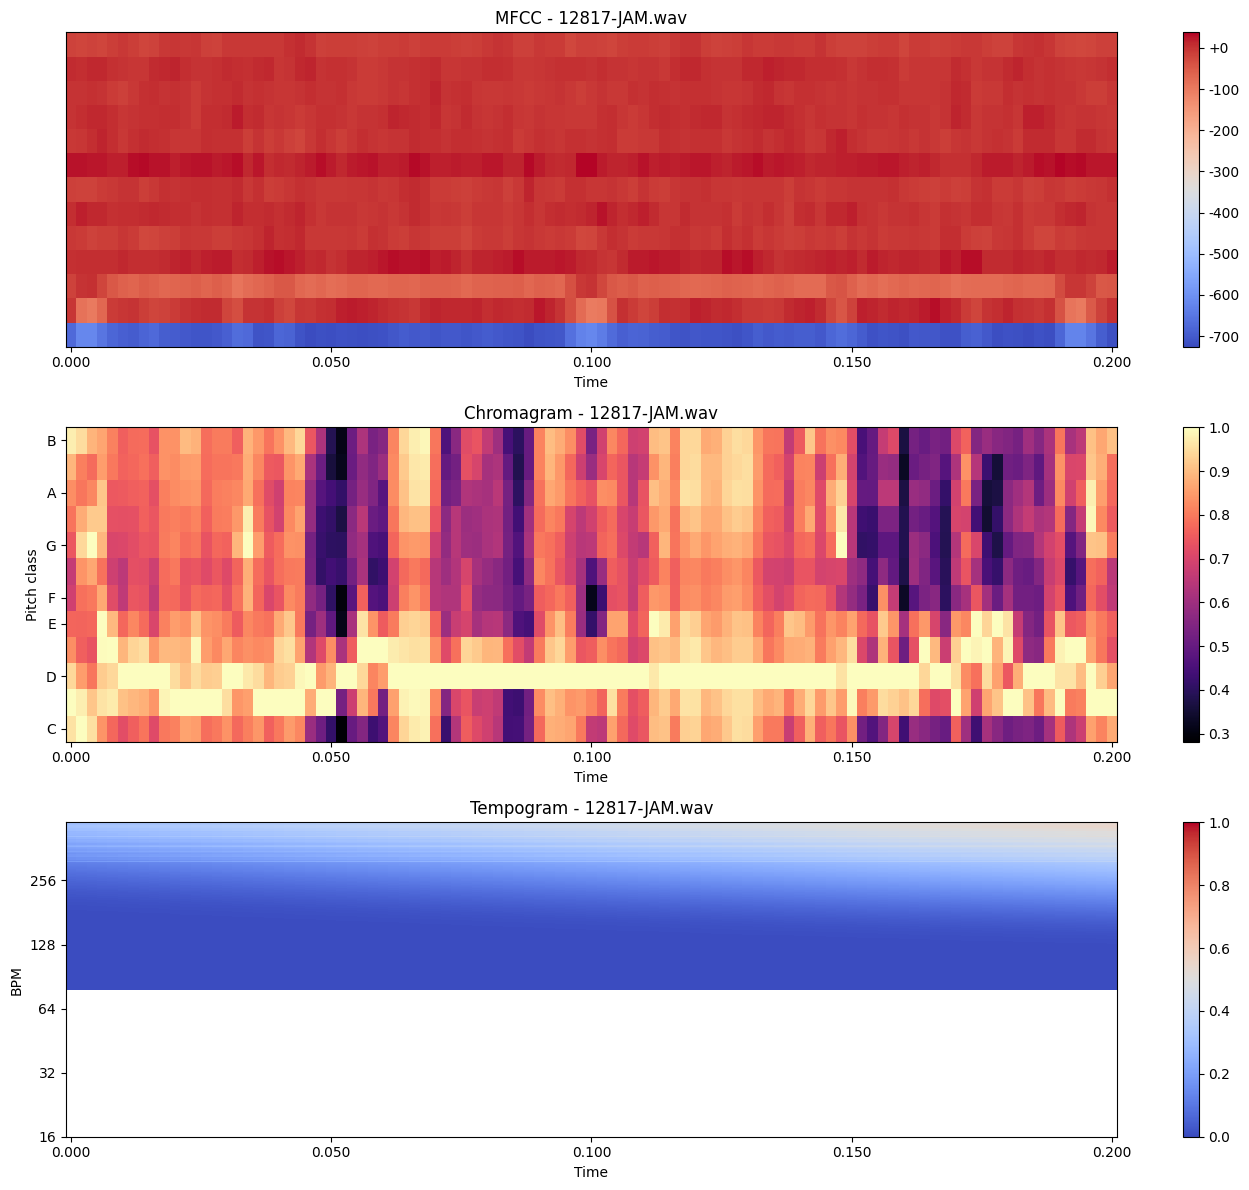


Information for 12817-JAM.wav:
Sample rate: 256000 Hz
Duration: 0.20 seconds
Number of samples: 51200
Estimated tempo: 315.79 BPM

--- File 3/5: 21054-StMARTIN.wav ---


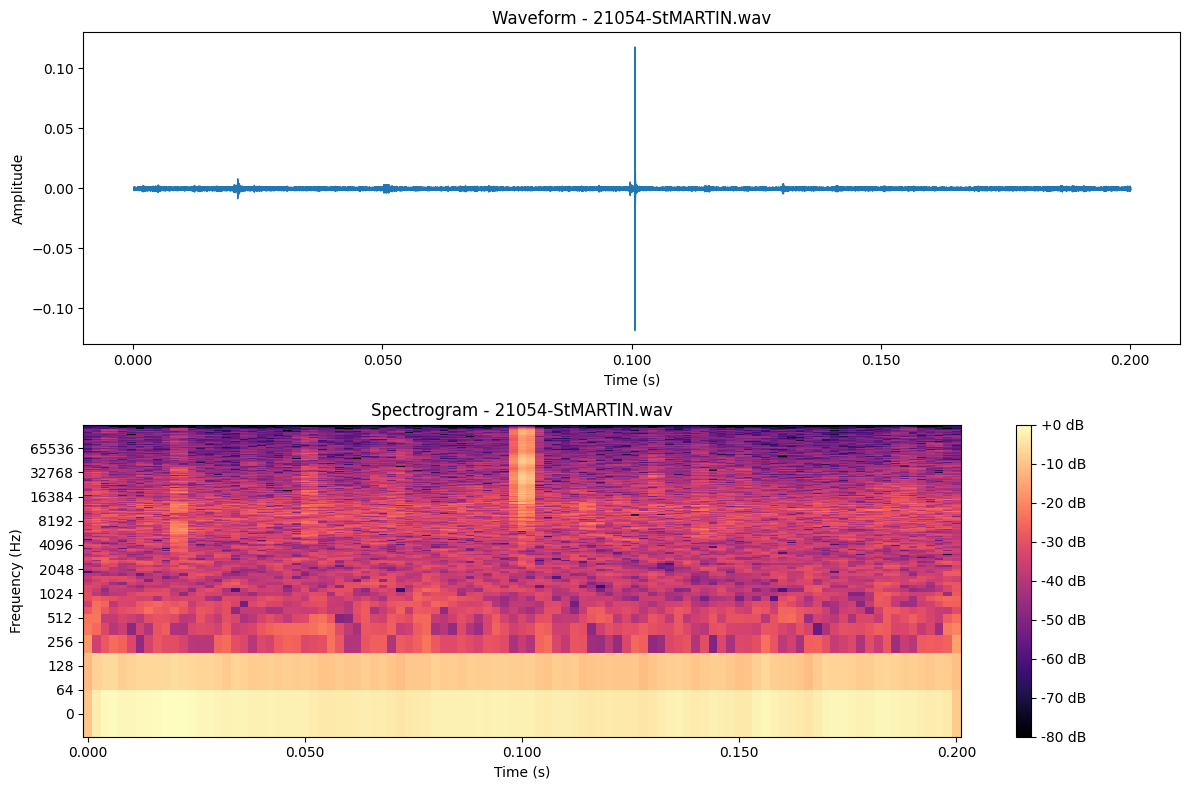

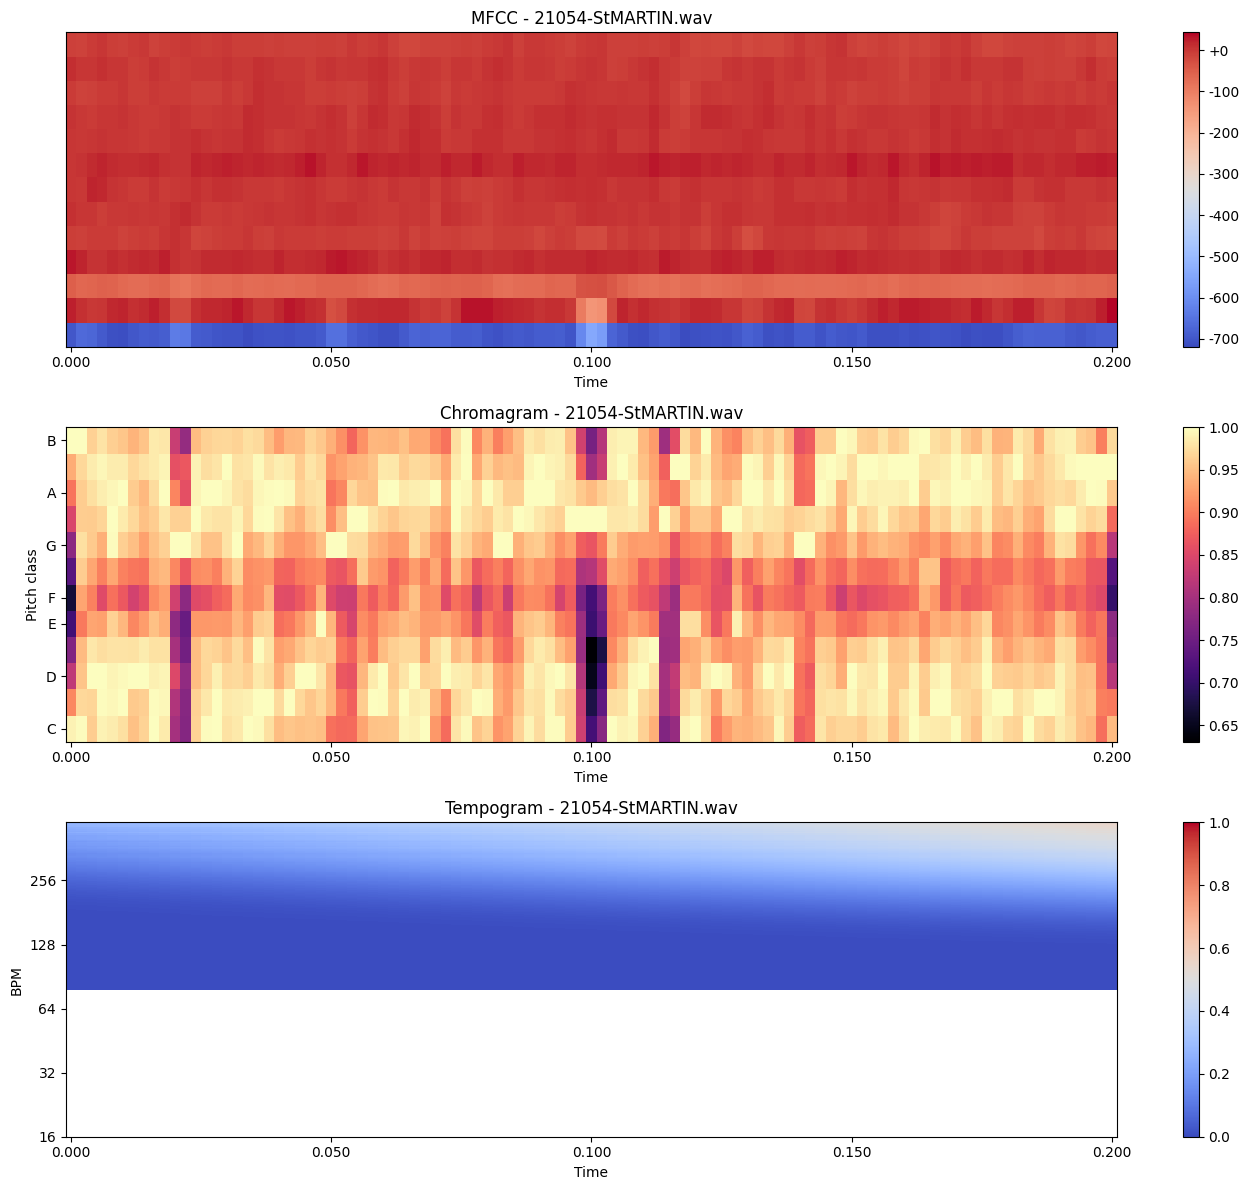


Information for 21054-StMARTIN.wav:
Sample rate: 256000 Hz
Duration: 0.20 seconds
Number of samples: 51200
Estimated tempo: 136.99 BPM

--- File 4/5: 02802-BON.wav ---


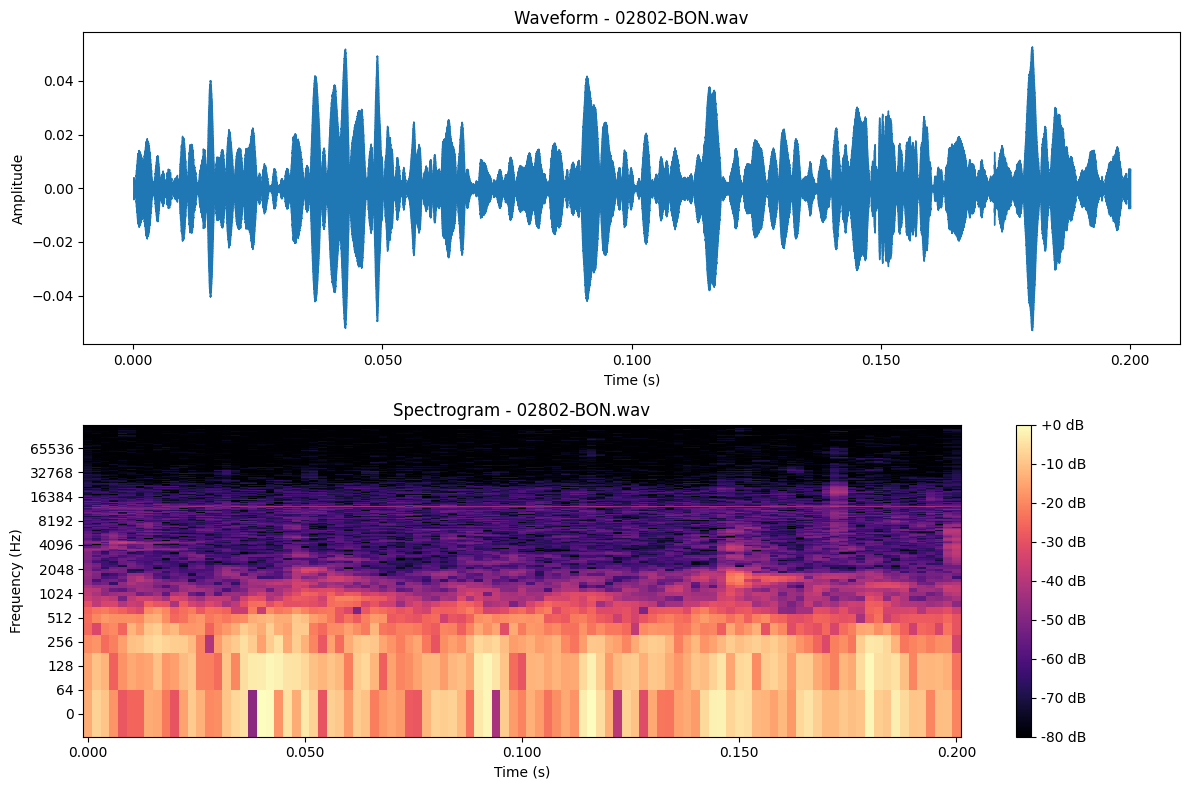

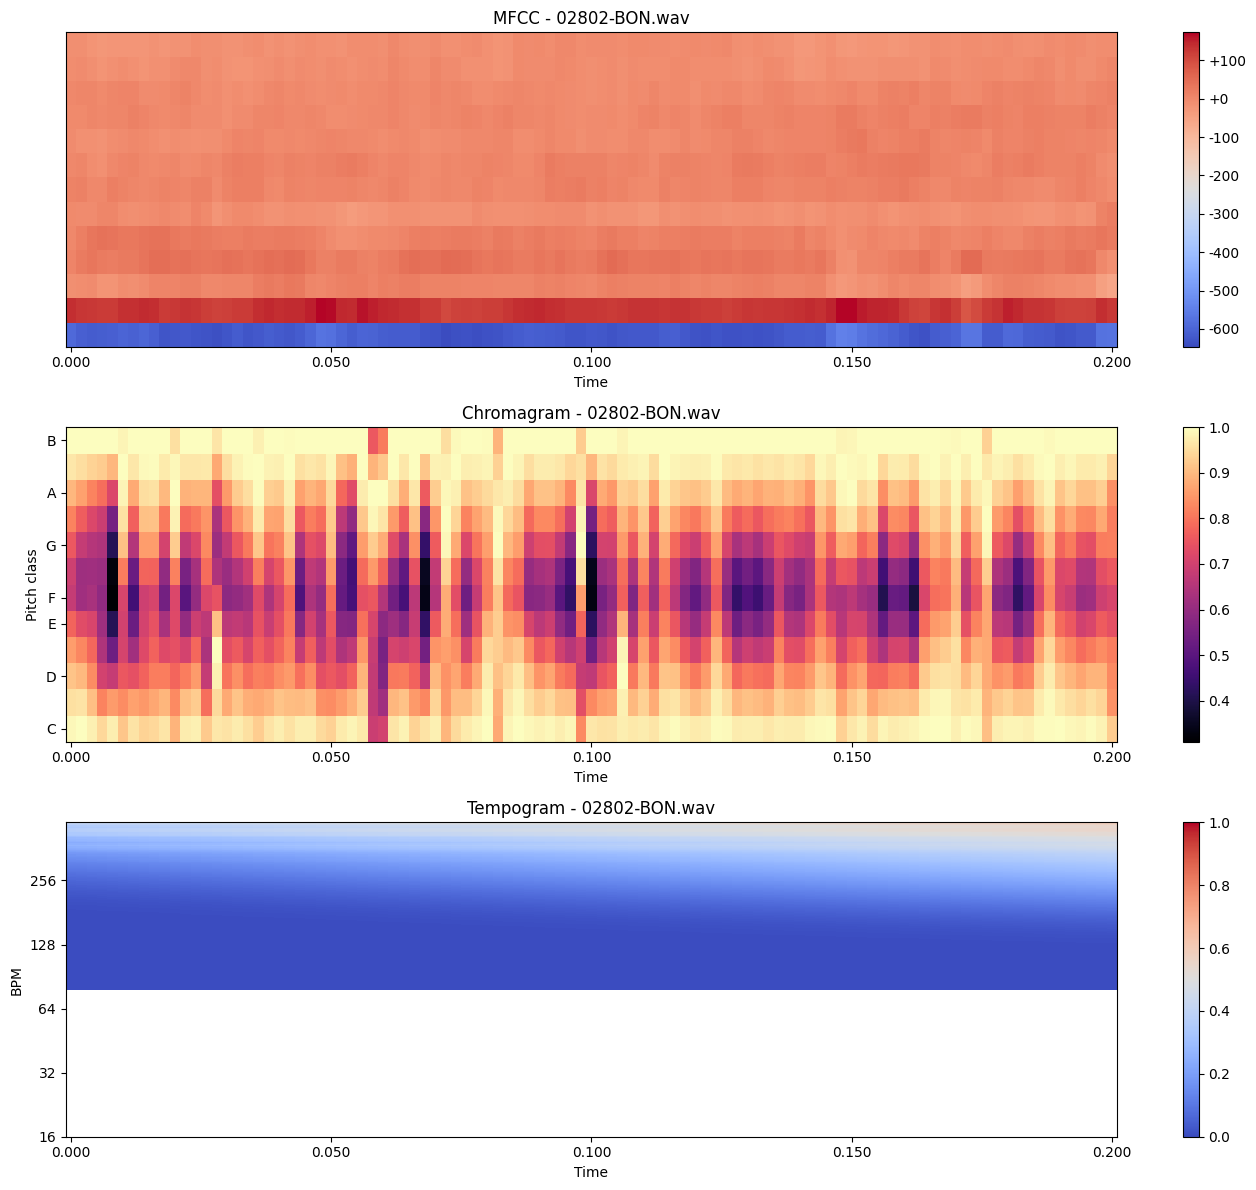


Information for 02802-BON.wav:
Sample rate: 256000 Hz
Duration: 0.20 seconds
Number of samples: 51200
Estimated tempo: 120.00 BPM

--- File 5/5: 22010-GUA.wav ---


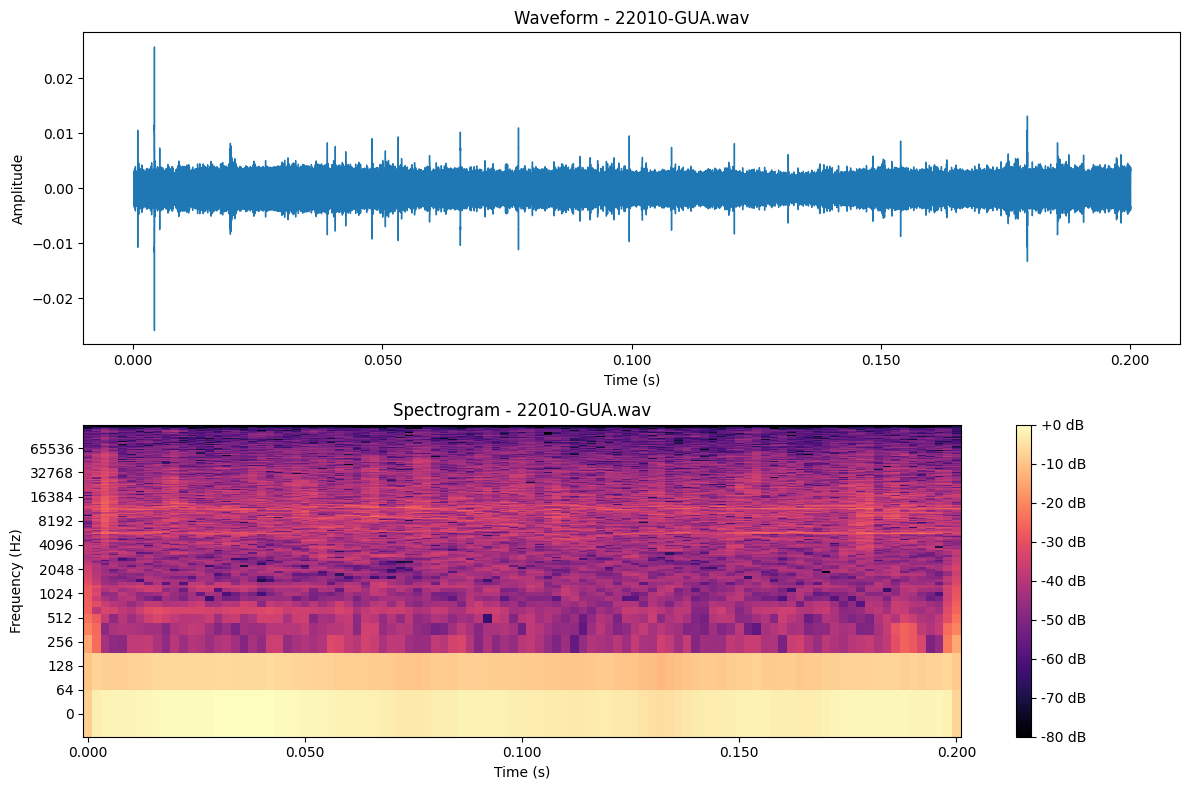

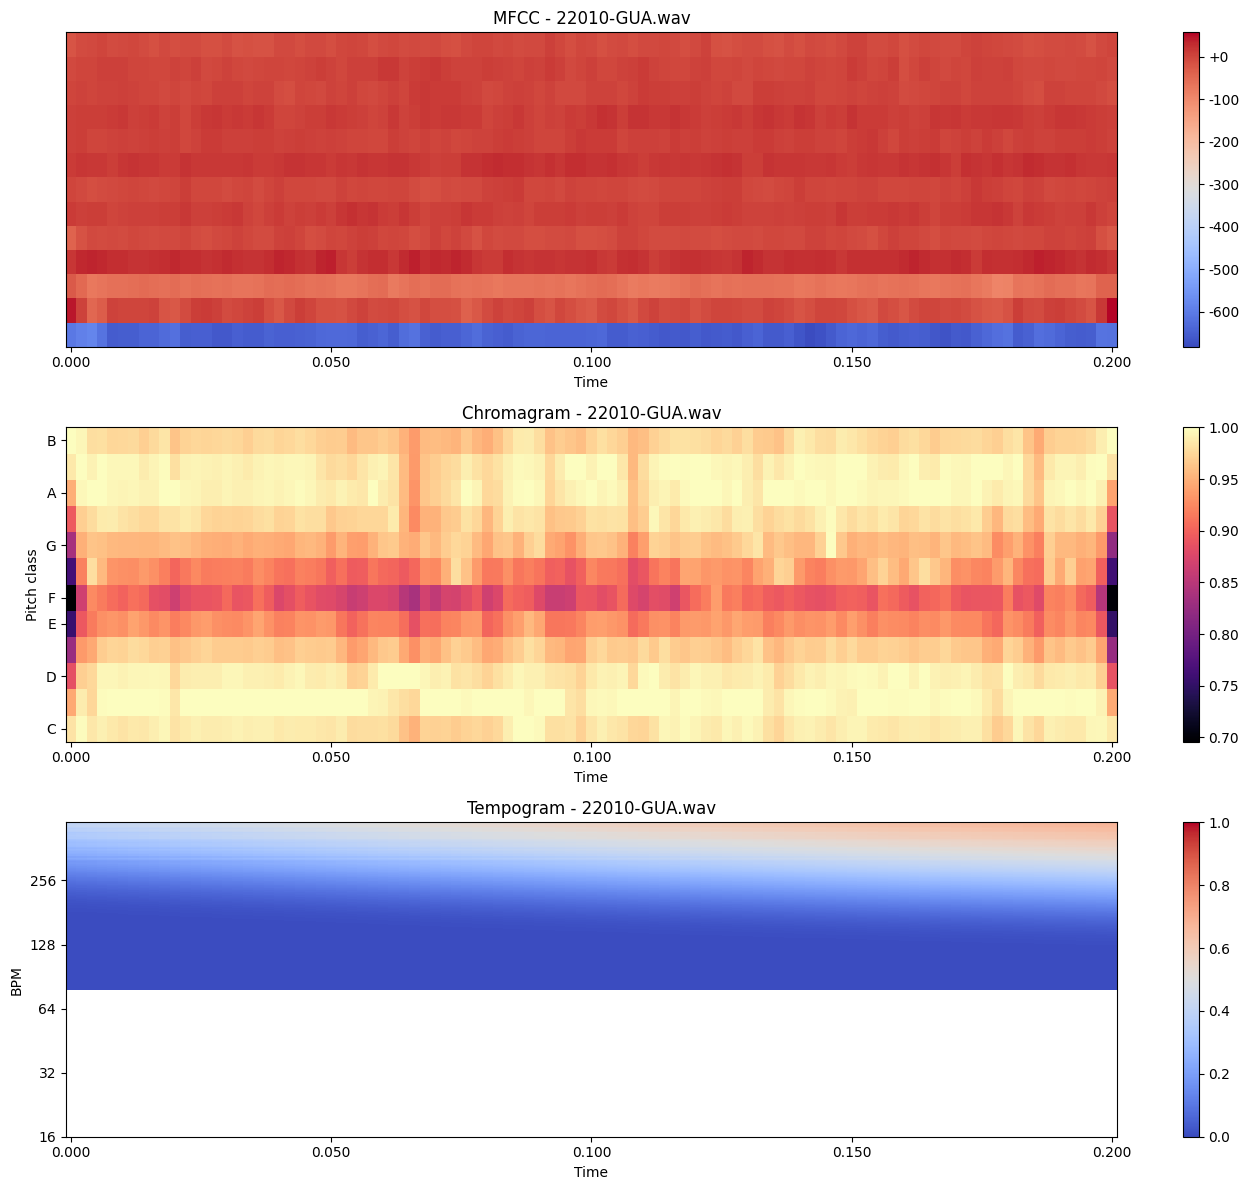


Information for 22010-GUA.wav:
Sample rate: 256000 Hz
Duration: 0.20 seconds
Number of samples: 51200
Estimated tempo: 136.99 BPM


In [16]:
# Illustrate only first 5 audios
audio_files = glob.glob(os.path.join(X_TRAIN_FOLDER_PATH, "*.wav"))[:5]

def visualize_audio(file, index):
    y, sr = librosa.load(file, sr=None)
    plt.figure(figsize=(12, 8))

    # 1. Waveform
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {os.path.basename(file)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

    # 2. Spectrogram
    plt.subplot(2, 1, 2)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {os.path.basename(file)}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')

    plt.tight_layout()
    plt.savefig(f'audio_visualization_{index}.png')
    plt.show()

    plt.figure(figsize=(14, 12))

    # 3. MFCC (Mel-Frequency Cepstral Coefficients)
    plt.subplot(3, 1, 1)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, fmax=sr/2)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time')
    plt.colorbar(format='%+2.0f')
    plt.title(f'MFCC - {os.path.basename(file)}')

    # 4. Chromagram
    plt.subplot(3, 1, 2)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma')
    plt.colorbar()
    plt.title(f'Chromagram - {os.path.basename(file)}')

    # 5. Tempogram
    plt.subplot(3, 1, 3)

    oenv = librosa.onset.onset_strength(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)
    librosa.display.specshow(tempogram, sr=sr, x_axis='time', y_axis='tempo')
    plt.colorbar()
    plt.title(f'Tempogram - {os.path.basename(file)}')

    plt.tight_layout()
    plt.savefig(f'advanced_visualization_{index}.png')
    plt.show()

    # Display information about the audio file
    duration = len(y) / sr
    print(f"\nInformation for {os.path.basename(file)}:")
    print(f"Sample rate: {sr} Hz")
    print(f"Duration: {duration:.2f} seconds")
    print(f"Number of samples: {len(y)}")

    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
        if isinstance(tempo, np.ndarray):
            tempo = float(tempo[0])
        print(f"Estimated tempo: {tempo:.2f} BPM")
    except Exception as e:
        print(f"Could not estimate tempo: {str(e)}")

        try:
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            dtempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
            print(f"Alternative estimated tempo: {float(dtempo):.2f} BPM")
        except:
            print("No tempo estimation method worked.")

for i, file in enumerate(audio_files):
    print(f"\n--- File {i+1}/{len(audio_files)}: {os.path.basename(file)} ---")
    visualize_audio(file, i+1)

## Feature Engineering

In [17]:
extractor = AudioFeatureExtractor()

# Prepare train data
train_features = extractor.extract_from_directory(X_TRAIN_DOSSIER_PATH)

train_features["File"] = train_features["File"].str.replace(r"^/content/data/data/X_train/", "", regex=True)
X_train_with_labels = pd.merge(train_features, y_train, left_on='File', right_on='id', how='inner')
X_train_with_labels.to_csv(TRAIN_PATH, index=False)

# Prepare test data
submit_features = extractor.extract_from_directory(X_SUBMIT_DOSSIER_PATH)
submit_features["File"] = submit_features["File"].str.replace(r"^/content/data/data/X_test/", "", regex=True)
submit_features.to_csv(X_SUBMIT_PATH, index=False)

Processing audio files:   0%|          | 1/23168 [00:03<23:18:40,  3.62s/it]/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Processing audio files:   0%|          | 0/950 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/librosa/feature/spectral.py:2148: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)
Processing audio files: 100%|██████████| 950/950 [01:06<00:00, 14.33it/s]


In [18]:
submit_features["File"] = submit_features["File"].str.replace(r"^/content/data/data/X_test/", "", regex=True)
submit_features.to_csv(X_SUBMIT_PATH, index=False)

In [19]:
audio_df = pd.read_csv(TRAIN_PATH)
audio_df_test = pd.read_csv(X_SUBMIT_PATH)

In [20]:
audio_df

,File,Peak Frequency,Mean ICI (s),SNR (dB),Kurtosis,Skewness,Amplitude Mean,Amplitude Std,Amplitude Min,Amplitude Max,...,Spectral Bandwidth Std,Spectral Bandwidth Min,Spectral Bandwidth Max,Spectral Flatness Mean,Spectral Flatness Std,Spectral Flatness Min,Spectral Flatness Max,id,pos_label,location
0,04207-GUA.wav,12250.0,0.042500,1.558417e-07,3.173746,1.804283,1.255659e-07,0.000663,-0.010412,0.013382,...,1384.552115,18588.841706,28803.176608,0.014046,0.008113,0.001884,0.061594,04207-GUA.wav,0.0,GUA
1,12817-JAM.wav,8875.0,0.047000,5.773229e-08,5.472332,1.159897,-9.288957e-08,0.000806,-0.033155,0.041290,...,1267.317392,21730.980975,28366.022073,0.018938,0.011973,0.010250,0.112567,12817-JAM.wav,1.0,JAM
2,21054-StMARTIN.wav,11500.0,0.069000,4.398152e-08,0.250403,0.866402,9.476827e-08,0.000942,-0.097391,0.059758,...,878.083707,23049.169277,28609.728043,0.018458,0.006601,0.009260,0.058547,21054-StMARTIN.wav,0.0,StMARTIN
3,02802-BON.wav,12375.0,0.047333,9.620291e-09,71.608412,6.384205,1.922935e-08,0.000409,-0.011881,0.010209,...,1456.081015,18333.556641,28674.283652,0.007166,0.002271,0.002597,0.022244,02802-BON.wav,0.0,BON
4,22010-GUA.wav,11625.0,0.047333,1.851512e-07,2.872843,1.538109,1.498437e-07,0.000726,-0.027257,0.008396,...,859.233973,22247.726535,26361.376967,0.016561,0.005205,0.010697,0.047826,22010-GUA.wav,0.0,GUA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23163,07030-BON.wav,51125.0,0.042667,1.954322e-08,60.307749,6.079092,-5.055849e-08,0.000754,-0.010268,0.010691,...,1927.290875,22710.814086,31906.888452,0.007651,0.004929,0.001940,0.038410,07030-BON.wav,0.0,BON
23164,21905-GUA.wav,11375.0,0.060667,9.416507e-08,8.917331,2.063888,-1.214888e-07,0.000825,-0.023157,0.014624,...,862.336842,22342.891248,26750.430907,0.016340,0.006652,0.009720,0.063795,21905-GUA.wav,0.0,GUA
23165,19218-GUA.wav,9750.0,0.054000,1.143975e-07,71.443743,6.089348,-9.933392e-08,0.000612,-0.013959,0.006939,...,957.948118,20841.132491,27176.414730,0.012378,0.002915,0.006023,0.026721,19218-GUA.wav,0.0,GUA
23166,18513-BON.wav,11875.0,0.052667,2.623632e-09,200.188267,11.433436,-8.606027e-09,0.000350,-0.002375,0.001882,...,624.146673,23617.076479,27402.896451,0.009827,0.004084,0.005760,0.042523,18513-BON.wav,0.0,BON


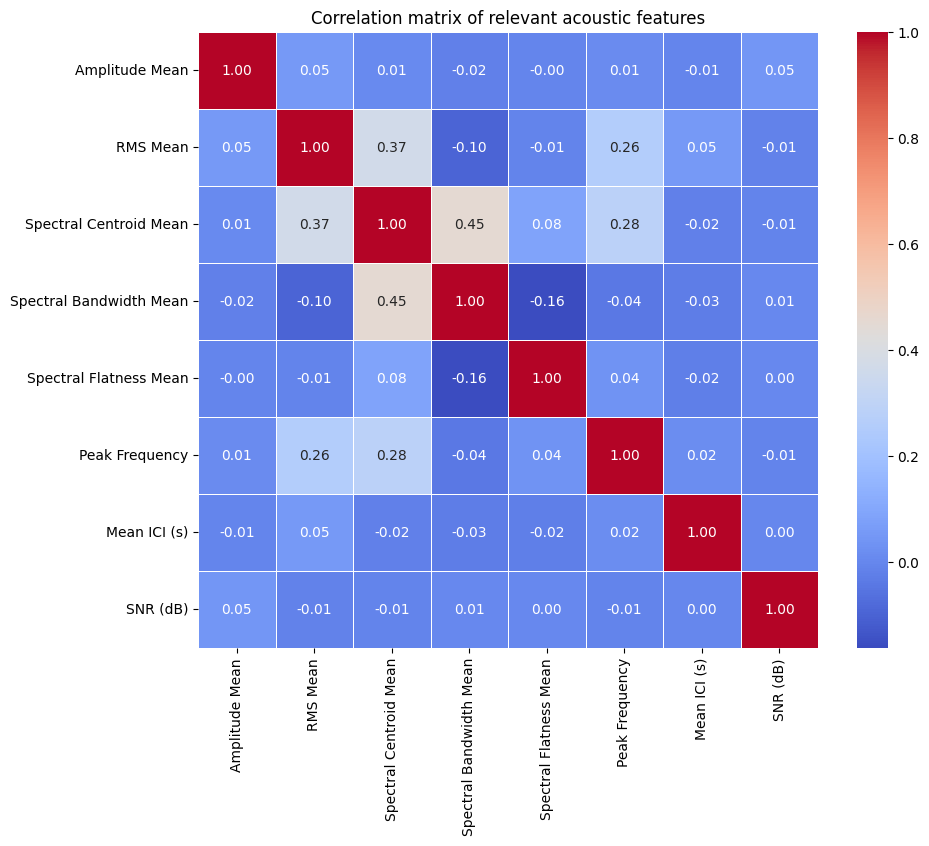

In [21]:
# We used only "average" features to avoid the repetition
selected_features = [
    "Amplitude Mean", "RMS Mean", "Spectral Centroid Mean",
    "Spectral Bandwidth Mean", "Spectral Flatness Mean", "Peak Frequency",
    "Mean ICI (s)", "SNR (dB)"
]


corr_matrix = audio_df[selected_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation matrix of relevant acoustic features")
plt.show()


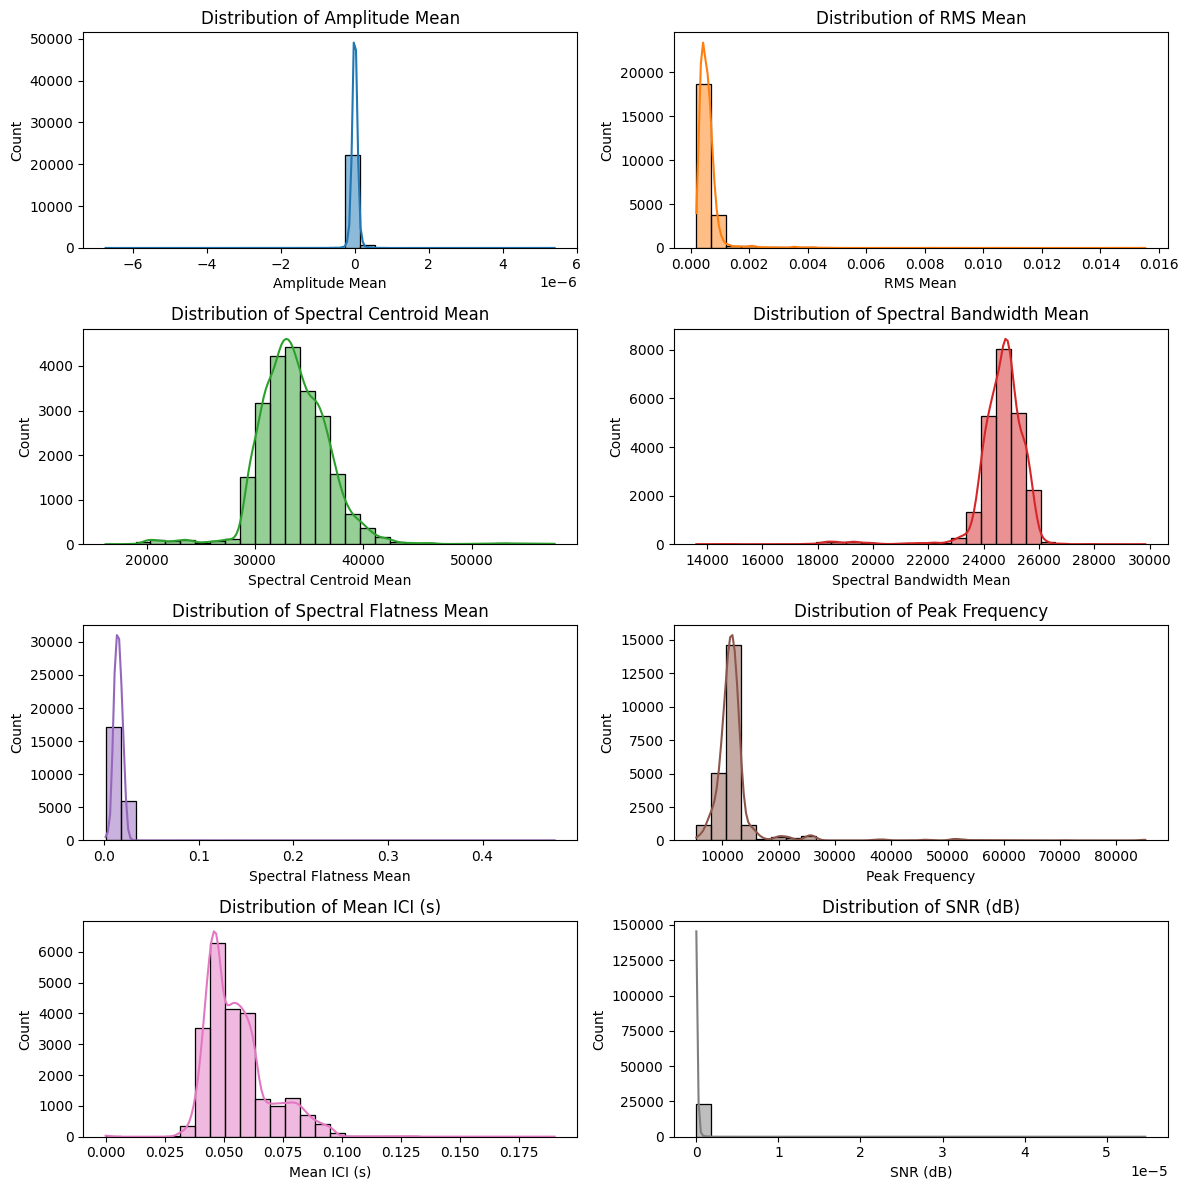

In [22]:
feature_pairs_mean = [
    ("Amplitude Mean", "RMS Mean"),
    ("Spectral Centroid Mean", "Spectral Bandwidth Mean"),
    ("Spectral Flatness Mean", "Peak Frequency"),
    ("Mean ICI (s)", "SNR (dB)")
]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f"]

fig, axes = plt.subplots(4, 2, figsize=(12, 12))

for i, (feature1, feature2) in enumerate(feature_pairs_mean):
    sns.histplot(audio_df[feature1], kde=True, bins=30, color=colors[2*i], ax=axes[i, 0])
    axes[i, 0].set_title(f"Distribution of {feature1}")

    sns.histplot(audio_df[feature2], kde=True, bins=30, color=colors[2*i+1], ax=axes[i, 1])
    axes[i, 1].set_title(f"Distribution of {feature2}")

plt.tight_layout()
plt.show()


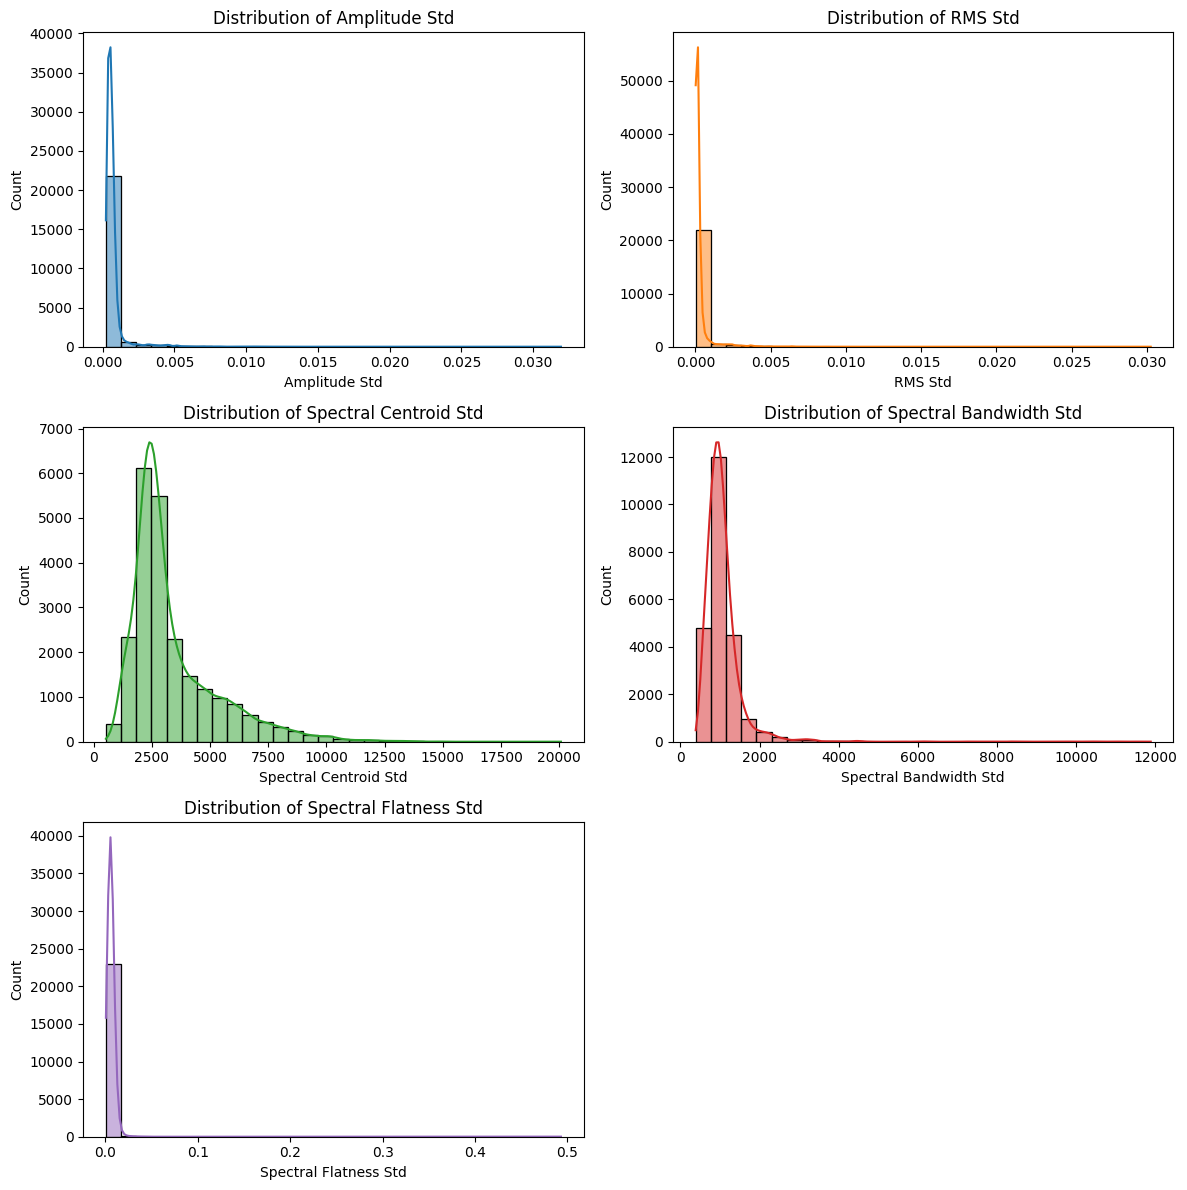

In [23]:
feature_pairs_std = [
    ("Amplitude Std", "RMS Std"),
    ("Spectral Centroid Std", "Spectral Bandwidth Std"),
    ("Spectral Flatness Std",)
]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for i, feature_pair in enumerate(feature_pairs_std):
    if len(feature_pair) == 2:
        feature1, feature2 = feature_pair
        sns.histplot(audio_df[feature1], kde=True, bins=30, color=colors[2*i], ax=axes[i, 0])
        axes[i, 0].set_title(f"Distribution of {feature1}")
        sns.histplot(audio_df[feature2], kde=True, bins=30, color=colors[2*i+1], ax=axes[i, 1])
        axes[i, 1].set_title(f"Distribution of {feature2}")
    else:
        feature1 = feature_pair[0]
        sns.histplot(audio_df[feature1], kde=True, bins=30, color=colors[2*i], ax=axes[i, 0])
        axes[i, 0].set_title(f"Distribution of {feature1}")
        axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


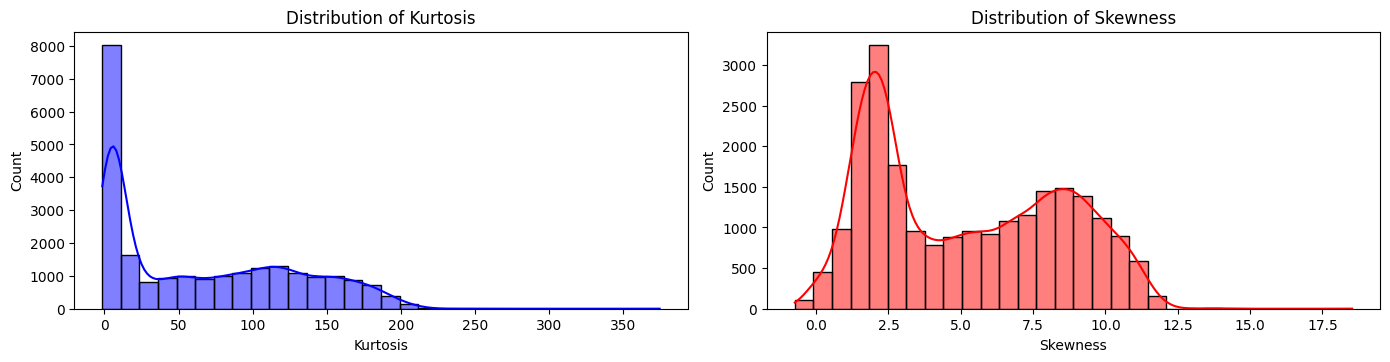

In [24]:
# Kurtosis and Skewness
plt.figure(figsize=(14, 10))

plt.subplot(3, 2, 1)
sns.histplot(audio_df["Kurtosis"], bins=30, kde=True, color="blue")
plt.xlabel("Kurtosis")
plt.ylabel("Count")
plt.title("Distribution of Kurtosis")

plt.subplot(3, 2, 2)
sns.histplot(audio_df["Skewness"], bins=30, kde=True, color="red")
plt.xlabel("Skewness")
plt.ylabel("Count")
plt.title("Distribution of Skewness")

plt.tight_layout()
plt.show()

In [25]:
audio_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Peak Frequency,23168.0,1.240984e+04,6.098091e+03,5.375000e+03,1.062500e+04,1.150000e+04,1.250000e+04,85125.000000
Mean ICI (s),23168.0,5.598574e-02,1.401548e-02,0.000000e+00,4.600000e-02,5.300000e-02,6.200000e-02,0.190000
SNR (dB),23168.0,9.478965e-08,6.391518e-07,9.643275e-16,5.359928e-09,2.907594e-08,9.346443e-08,0.000055
Kurtosis,23168.0,6.595930e+01,6.200158e+01,-1.503280e+00,6.874370e+00,5.026865e+01,1.182316e+02,374.468486
Skewness,23168.0,5.174882e+00,3.286132e+00,-7.404343e-01,2.149902e+00,4.782926e+00,8.179071e+00,18.529687
Amplitude Mean,23168.0,7.223526e-10,1.295339e-07,-6.740153e-06,-4.526268e-08,2.868616e-10,4.550048e-08,0.000005
Amplitude Std,23168.0,7.247572e-04,9.448859e-04,2.261409e-04,3.951530e-04,5.526882e-04,7.151943e-04,0.031933
Amplitude Min,23168.0,-2.664208e-02,5.041453e-02,-8.314882e-01,-2.424825e-02,-1.394995e-02,-7.532914e-03,-0.001128
Amplitude Max,23168.0,2.343714e-02,5.519005e-02,1.036382e-03,6.676659e-03,1.035392e-02,1.669220e-02,0.780934
RMS Mean,23168.0,6.151403e-04,6.272035e-04,1.939663e-04,3.835386e-04,5.253917e-04,6.596925e-04,0.015533


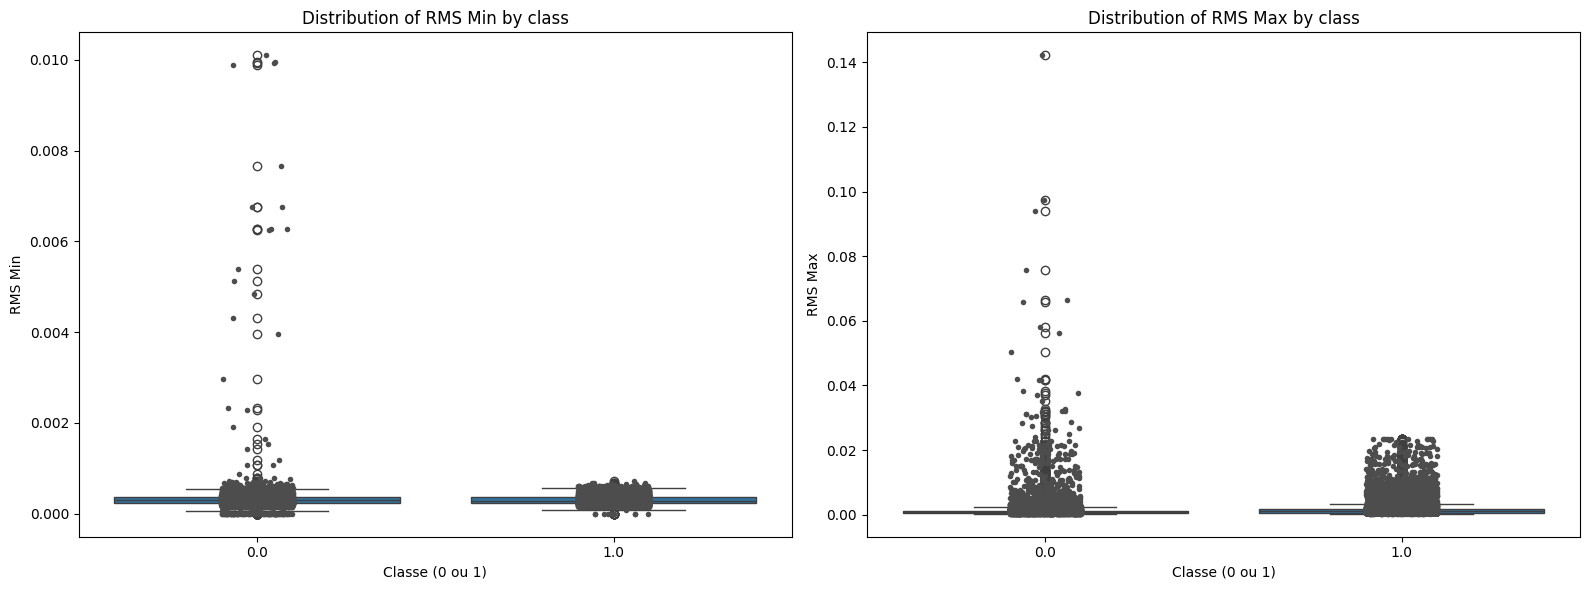


Statistics of RMS Min:
             count      mean       std  min       25%       50%       75%  \
pos_label                                                                   
0.0        13718.0  0.000314  0.000248  0.0  0.000241  0.000300  0.000360   
1.0         9450.0  0.000307  0.000095  0.0  0.000239  0.000278  0.000368   

                max  
pos_label            
0.0        0.010099  
1.0        0.000722  

Statistics of RMS Max:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0  0.001297  0.002995  0.000276  0.000566  0.000876   
1.0         9450.0  0.001971  0.002749  0.000304  0.000654  0.001099   

                75%       max  
pos_label                      
0.0        0.001236  0.142205  
1.0        0.001754  0.023511  


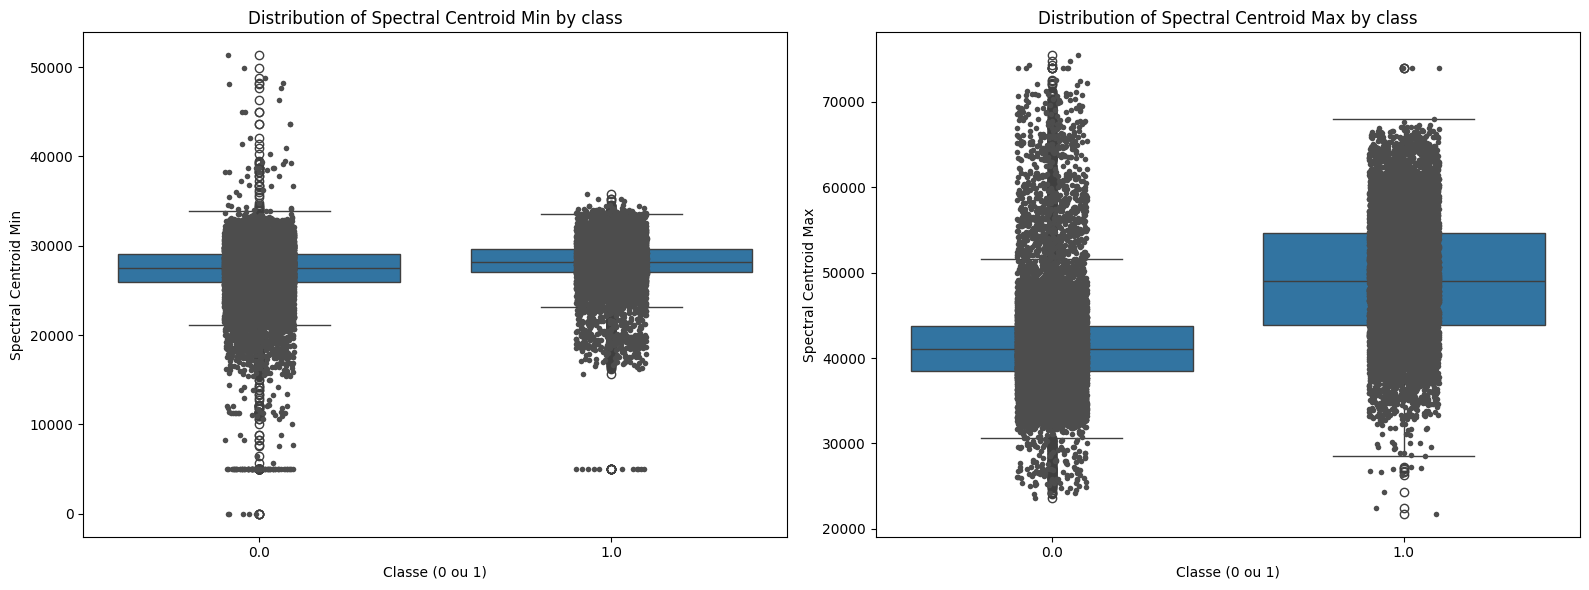


Statistics of Spectral Centroid Min:
             count          mean          std            min           25%  \
pos_label                                                                    
0.0        13718.0  27085.853133  3440.497315  6.958080e-315  25908.581989   
1.0         9450.0  28082.583572  2661.194765   4.963286e+03  27058.360839   

                    50%           75%           max  
pos_label                                            
0.0        27535.523342  29108.592945  51322.991206  
1.0        28215.229422  29669.588623  35807.768646  

Statistics of Spectral Centroid Max:
             count          mean          std           min           25%  \
pos_label                                                                   
0.0        13718.0  41706.120199  5991.121602  23642.572877  38494.514556   
1.0         9450.0  49332.175453  7298.110621  21768.720365  43850.419157   

                    50%           75%           max  
pos_label                       

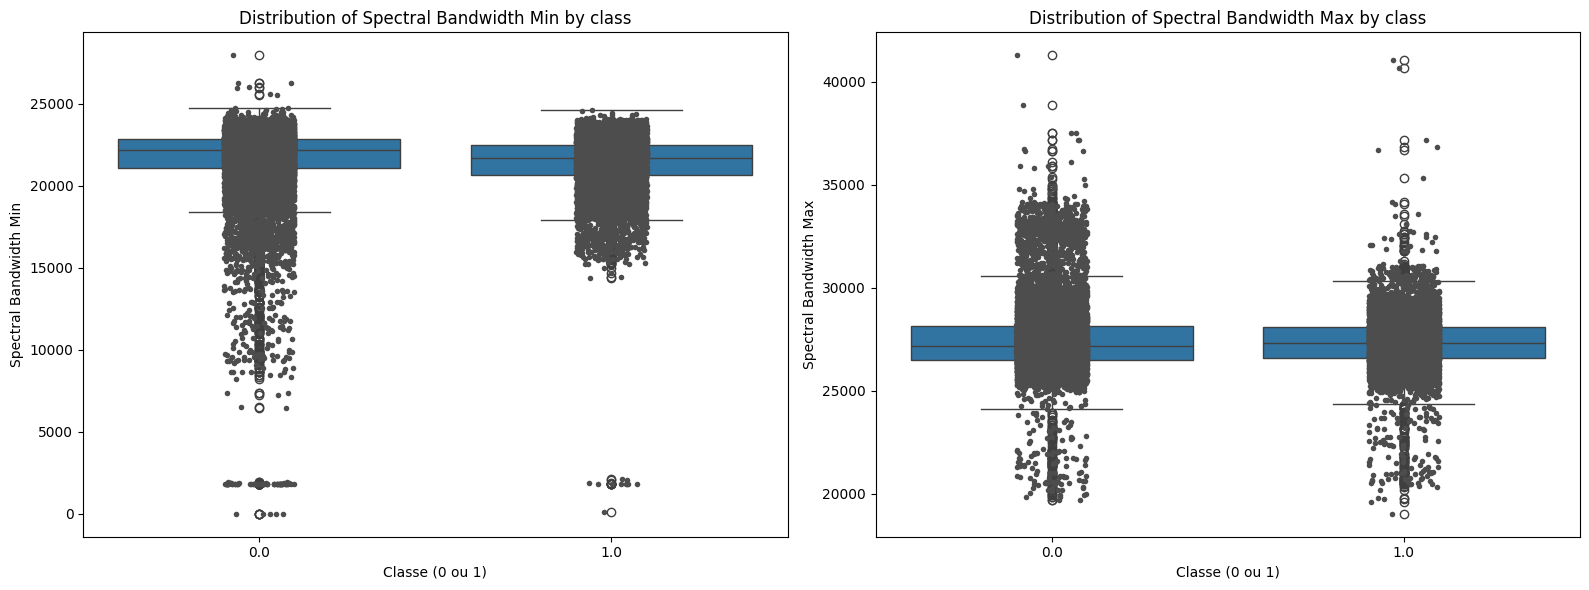


Statistics of Spectral Bandwidth Min:
             count          mean          std            min           25%  \
pos_label                                                                    
0.0        13718.0  21529.134336  2445.152661  2.562519e-155  21051.332114   
1.0         9450.0  21361.290816  1687.879336   8.838922e+01  20650.311320   

                    50%           75%           max  
pos_label                                            
0.0        22149.955574  22819.240162  27949.877710  
1.0        21693.153934  22466.816645  24635.340084  

Statistics of Spectral Bandwidth Max:
             count          mean          std           min           25%  \
pos_label                                                                   
0.0        13718.0  27494.728006  1692.125523  19686.817316  26498.171958   
1.0         9450.0  27319.132664  1290.533851  19019.190762  26559.485364   

                    50%           75%           max  
pos_label                     

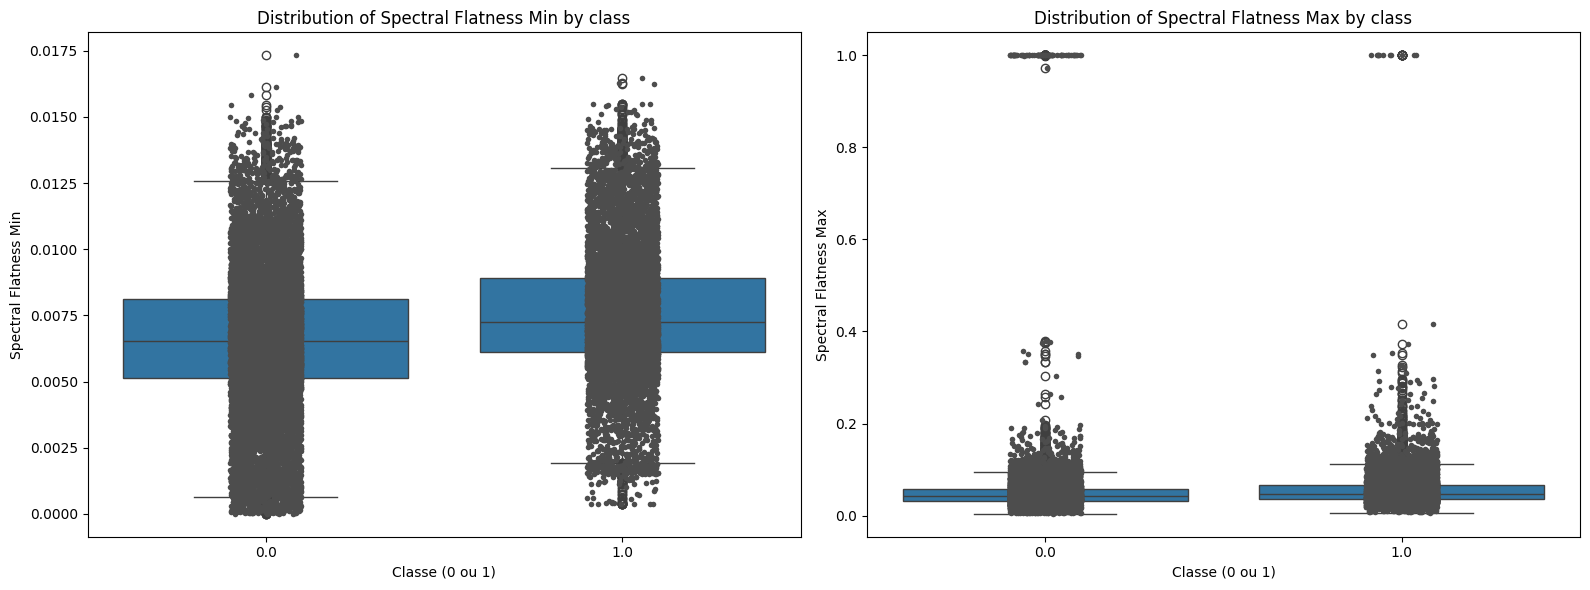


Statistics of Spectral Flatness Min:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0  0.006468  0.002729  0.000005  0.005121  0.006547   
1.0         9450.0  0.007547  0.002481  0.000371  0.006115  0.007233   

                75%       max  
pos_label                      
0.0        0.008114  0.017329  
1.0        0.008903  0.016480  

Statistics of Spectral Flatness Max:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0  0.051687  0.073083  0.003843  0.031505  0.042338   
1.0         9450.0  0.055969  0.044089  0.005378  0.035310  0.047563   

                75%  max  
pos_label                 
0.0        0.056793  1.0  
1.0        0.066440  1.0  


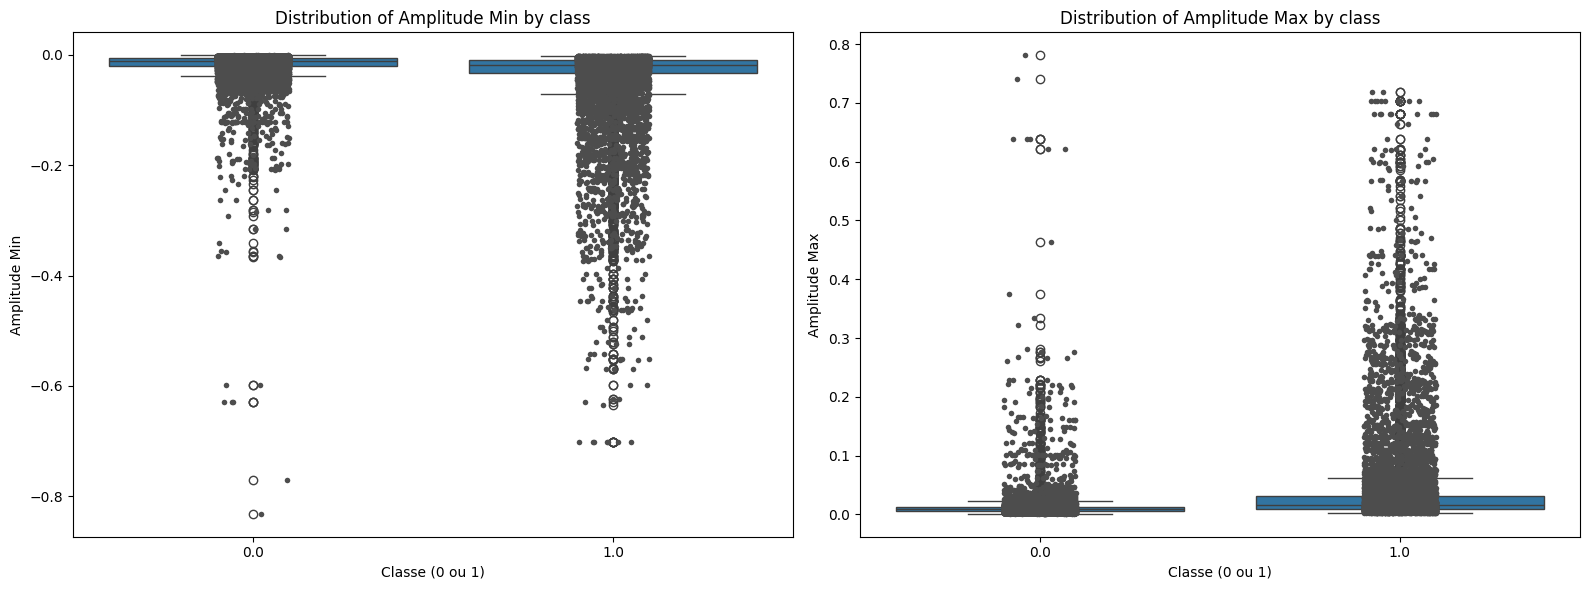


Statistics of Amplitude Min:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0 -0.017064  0.025626 -0.831488 -0.019784 -0.012066   
1.0         9450.0 -0.040547  0.070368 -0.700993 -0.034012 -0.017886   

                75%       max  
pos_label                      
0.0       -0.006666 -0.001128  
1.0       -0.008939 -0.001788  

Statistics of Amplitude Max:
             count      mean       std       min       25%       50%  \
pos_label                                                              
0.0        13718.0  0.011330  0.022266  0.001036  0.005524  0.008735   
1.0         9450.0  0.041012  0.078909  0.001774  0.008964  0.015498   

                75%       max  
pos_label                      
0.0        0.012284  0.780934  
1.0        0.030525  0.717707  


In [26]:
features_min_max = [
    ("RMS Min", "RMS Max"),
    ("Spectral Centroid Min", "Spectral Centroid Max"),
    ("Spectral Bandwidth Min", "Spectral Bandwidth Max"),
    ("Spectral Flatness Min", "Spectral Flatness Max"),
    ("Amplitude Min", "Amplitude Max")
]

for feature_min, feature_max in features_min_max:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.boxplot(x='pos_label', y=feature_min, data=audio_df, ax=axes[0])
    sns.stripplot(x='pos_label', y=feature_min, data=audio_df,
                  size=4, color='.3', linewidth=0, ax=axes[0])
    axes[0].set_title(f'Distribution of {feature_min} by class')
    axes[0].set_xlabel('Classe (0 ou 1)')
    axes[0].set_ylabel(feature_min)

    sns.boxplot(x='pos_label', y=feature_max, data=audio_df, ax=axes[1])
    sns.stripplot(x='pos_label', y=feature_max, data=audio_df,
                  size=4, color='.3', linewidth=0, ax=axes[1])
    axes[1].set_title(f'Distribution of {feature_max} by class')
    axes[1].set_xlabel('Classe (0 ou 1)')
    axes[1].set_ylabel(feature_max)

    plt.tight_layout()
    plt.show()

    # Descriptive statistics for each variable
    print(f"\nStatistics of {feature_min}:")
    print(audio_df.groupby('pos_label')[feature_min].describe())
    print(f"\nStatistics of {feature_max}:")
    print(audio_df.groupby('pos_label')[feature_max].describe())


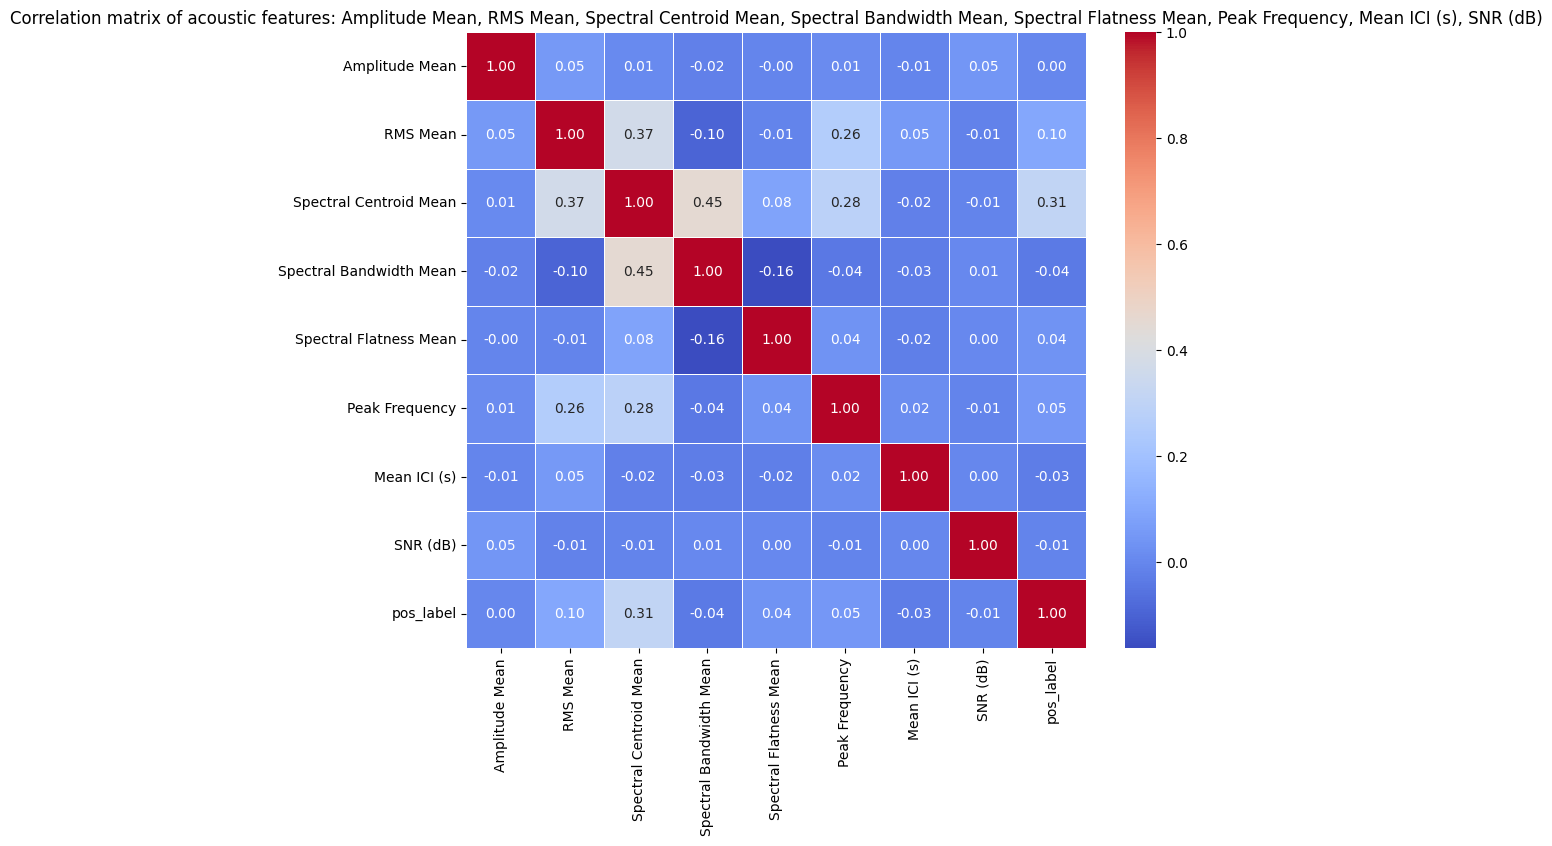

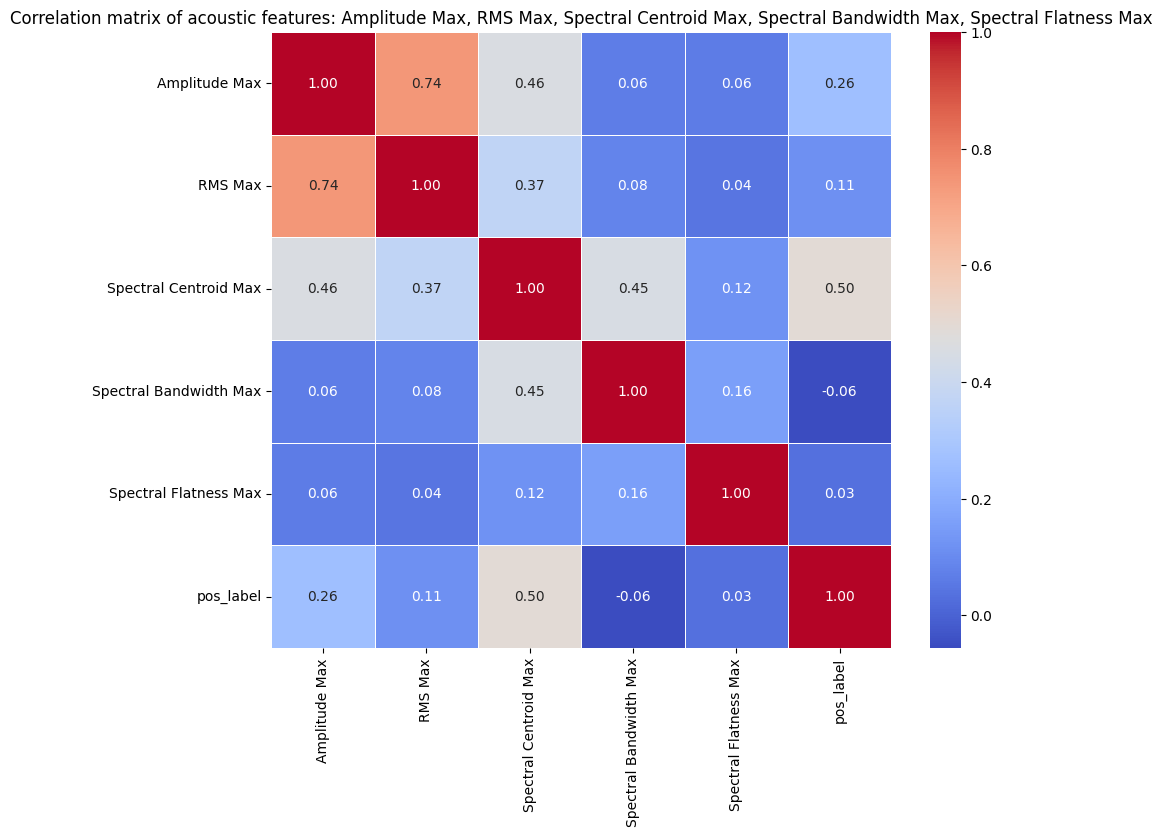

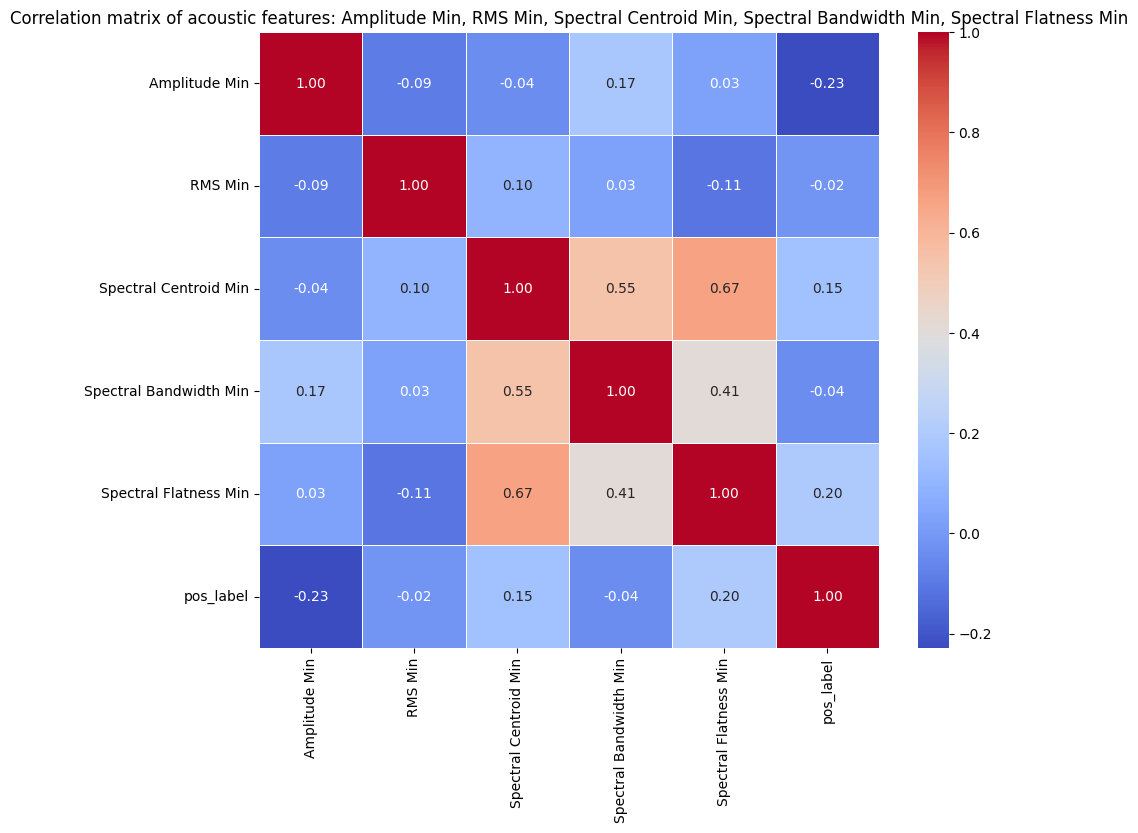

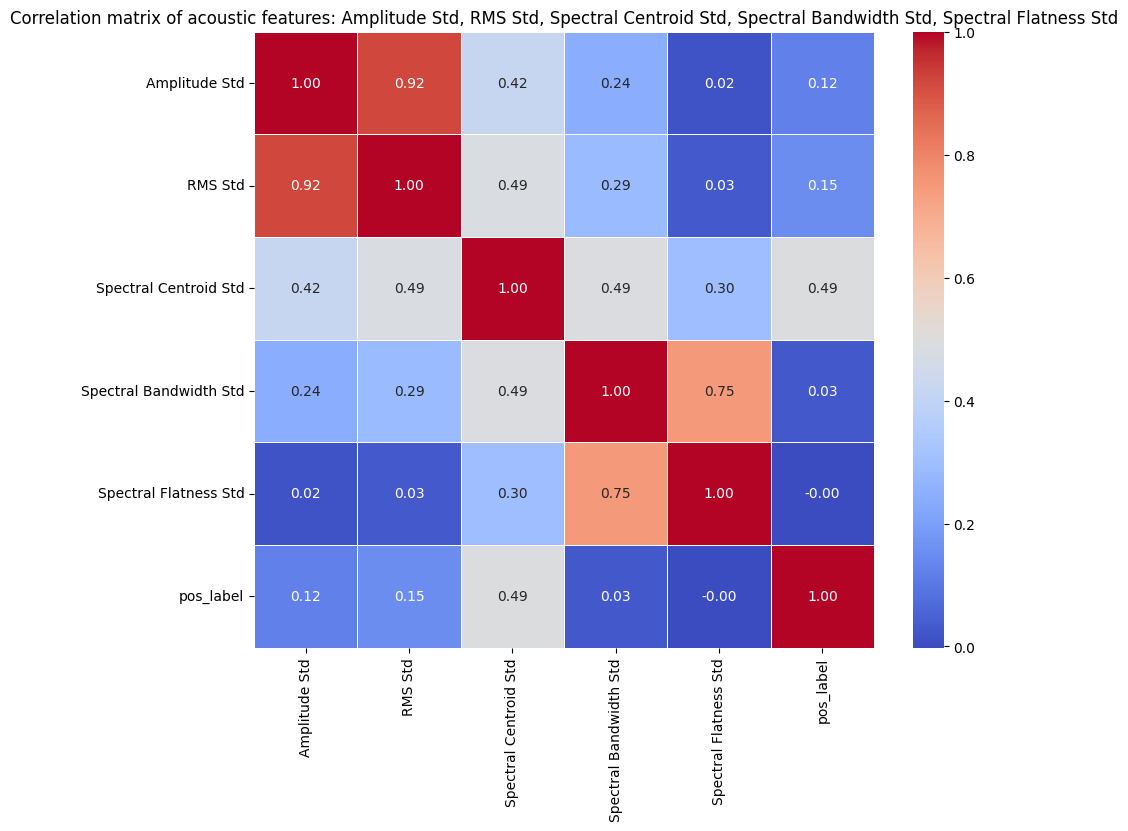

In [27]:
# Sélectionner les caractéristiques à analyser
selected_features_mean = [
    "Amplitude Mean", "RMS Mean", "Spectral Centroid Mean",
    "Spectral Bandwidth Mean", "Spectral Flatness Mean", "Peak Frequency",
    "Mean ICI (s)", "SNR (dB)", "pos_label"
]

selected_features_max = [
    "Amplitude Max", "RMS Max", "Spectral Centroid Max",
    "Spectral Bandwidth Max", "Spectral Flatness Max", "pos_label"
]

selected_features_min = [
    "Amplitude Min", "RMS Min", "Spectral Centroid Min",
    "Spectral Bandwidth Min", "Spectral Flatness Min", "pos_label"
]

selected_features_std = [
    "Amplitude Std", "RMS Std", "Spectral Centroid Std",
    "Spectral Bandwidth Std", "Spectral Flatness Std", "pos_label"
]

# Correlation matrix for each group
features_list = [selected_features_mean, selected_features_max, selected_features_min, selected_features_std]

for selected_features in features_list:
    corr_matrix = audio_df[selected_features].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
    plt.title(f"Correlation matrix of acoustic features: {', '.join(selected_features[:-1])}")
    plt.show()
